In [1]:
import pandas as pd

# Predicting the Sale Price of Bulldozers

## 1. Probem Definition

> Predict price of a bulldozer given its characteristics and prices of a similar bulldozers that were sold previously

## 2. Data

> Blue Book for Bulldozers  

>3 main datasets:  
>- Train.csv is the training set, which contains data through the end of 2011.
> - Valid.csv is the validation set, which contains data from January 1, 2012 - April 30, 2012 You make predictions on this set throughout the majority of the competition. Your score on this set is used to create the public leaderboard.
>- Test.csv is the test set, which won't be released until the last week of the competition. It contains data from May 1, 2012 - November 2012. Your score on the test set determines your final rank for the competition.


## 3. Evaluation

> RMSLE (root mean squared log error) between the actual and predicted auction prices.

**Note**: The goal for most regression evaluation metrics is to minimize the error.

## 4. Features

The key fields are in train.csv are:  
- SalesID: the uniue identifier of the sale
- MachineID: the unique identifier of a machine.  A machine can be sold multiple times
- saleprice: what the machine sold for at auction (only provided in train.csv)
- saledate: the date of the sale

In [2]:
features_dictionary = pd.read_excel('../data/Data Dictionary.xlsx', index_col=0)
features_dictionary.drop(['Unnamed: 2'], axis=1, inplace=True)
features_dictionary

C:\Users\whyko\miniconda3\envs\doz\lib\site-packages\openpyxl\worksheet\_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,Description
Variable,
SalesID,unique identifier of a particular sale of a ...
MachineID,identifier for a particular machine; machin...
ModelID,identifier for a unique machine model (i.e. ...
datasource,source of the sale record; some sources are...
auctioneerID,"identifier of a particular auctioneer, i.e. ..."
YearMade,year of manufacturer of the Machine
MachineHoursCurrentMeter,current usage of the machine in hours at tim...
UsageBand,"value (low, medium, high) calculated compari..."
Saledate,time of sale


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [4]:
# set low memory False because of warning
df = pd.read_csv('../data/TrainAndValid.csv', low_memory=False, parse_dates=['saledate'])

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 53 columns):
 #   Column                    Non-Null Count   Dtype         
---  ------                    --------------   -----         
 0   SalesID                   412698 non-null  int64         
 1   SalePrice                 412698 non-null  float64       
 2   MachineID                 412698 non-null  int64         
 3   ModelID                   412698 non-null  int64         
 4   datasource                412698 non-null  int64         
 5   auctioneerID              392562 non-null  float64       
 6   YearMade                  412698 non-null  int64         
 7   MachineHoursCurrentMeter  147504 non-null  float64       
 8   UsageBand                 73670 non-null   object        
 9   saledate                  412698 non-null  datetime64[ns]
 10  fiModelDesc               412698 non-null  object        
 11  fiBaseModel               412698 non-null  object        
 12  fi

In [6]:
# transpose to see all columns
df.head().T

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000.0,57000.0,10000.0,38500.0,11000.0
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3.0,3.0,3.0,3.0,3.0
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68.0,4640.0,2838.0,3486.0,722.0
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [7]:
df.isna().sum()

SalesID                          0
SalePrice                        0
MachineID                        0
ModelID                          0
datasource                       0
auctioneerID                 20136
YearMade                         0
MachineHoursCurrentMeter    265194
UsageBand                   339028
saledate                         0
fiModelDesc                      0
fiBaseModel                      0
fiSecondaryDesc             140727
fiModelSeries               354031
fiModelDescriptor           337882
ProductSize                 216605
fiProductClassDesc               0
state                            0
ProductGroup                     0
ProductGroupDesc                 0
Drive_System                305611
Enclosure                      334
Forks                       214983
Pad_Type                    331602
Ride_Control                259970
Stick                       331602
Transmission                224691
Turbocharged                331602
Blade_Extension     

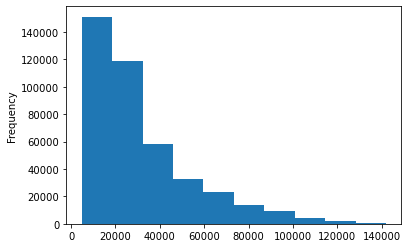

In [8]:
df.SalePrice.plot.hist();

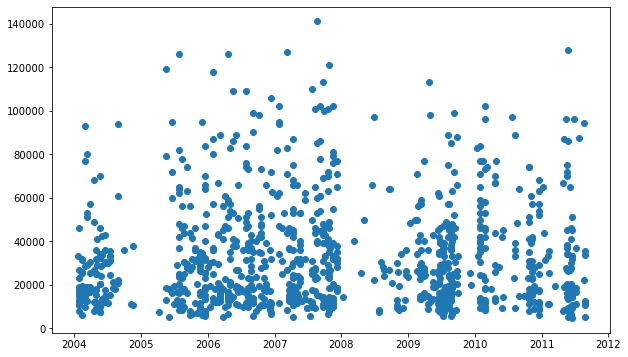

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(df.saledate[:1000], df.SalePrice[:1000])

### Sort DataFrame by saledate

In [10]:
df.sort_values(by=['saledate'], inplace=True, ascending=True)
df_copy = df.copy()

### Feature Engineering

In [11]:
df_copy['saleYear'] = df.saledate.dt.year
df_copy['saleMonth'] = df.saledate.dt.month
df_copy['saleDay'] = df.saledate.dt.day
df_copy['saleDayOfWeek'] = df.saledate.dt.dayofweek
df_copy['saleDayOfYear'] = df.saledate.dt.dayofyear
df_copy['saleIsQuarterEnd'] = df.saledate.dt.is_quarter_end
df_copy['saleIsQuarterStart'] = df.saledate.dt.is_quarter_start

In [12]:
df_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
saledate,1989-01-17 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00,1989-01-31 00:00:00


In [13]:
df_copy.drop('saledate', axis=1, inplace=True)

## 5. Modeling

* RandomForestRegressor

Model-driven EDA

### Convert strings to categories, impute missing data

In [14]:
for label, content in df_copy.items():
    if pd.api.types.is_string_dtype(content):
        # print(label)
        df_copy[label] = content.astype('category')

In [15]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412698 entries, 205615 to 409203
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype   
---  ------                    --------------   -----   
 0   SalesID                   412698 non-null  int64   
 1   SalePrice                 412698 non-null  float64 
 2   MachineID                 412698 non-null  int64   
 3   ModelID                   412698 non-null  int64   
 4   datasource                412698 non-null  int64   
 5   auctioneerID              392562 non-null  float64 
 6   YearMade                  412698 non-null  int64   
 7   MachineHoursCurrentMeter  147504 non-null  float64 
 8   UsageBand                 73670 non-null   category
 9   fiModelDesc               412698 non-null  category
 10  fiBaseModel               412698 non-null  category
 11  fiSecondaryDesc           271971 non-null  category
 12  fiModelSeries             58667 non-null   category
 13  fiModelDescriptor       

In [16]:
df_copy.head().T

,205615,274835,141296,212552,62755
SalesID,1646770,1821514,1505138,1671174,1329056
SalePrice,9500.0,14000.0,50000.0,16000.0,22000.0
MachineID,1126363,1194089,1473654,1327630,1336053
ModelID,8434,10150,4139,8591,4089
datasource,132,132,132,132,132
auctioneerID,18.0,99.0,99.0,99.0,99.0
YearMade,1974,1980,1978,1980,1984
MachineHoursCurrentMeter,NaN,NaN,NaN,NaN,NaN
UsageBand,NaN,NaN,NaN,NaN,NaN
fiModelDesc,TD20,A66,D7G,A62,D3B


In [17]:
df_copy.state.cat.codes

205615    43
274835     8
141296     8
212552     8
62755      8
          ..
410879     4
412476     4
411927     4
407124     4
409203     4
Length: 412698, dtype: int8

### Save preprocessed data

In [18]:
df_copy.to_csv('../data/train_copy.csv', index=False)

In [19]:
df_copy = pd.read_csv('../data/train_copy.csv', low_memory=False)

## Fill missing data

In [20]:
for label, content in df_copy.items():
    if pd.api.types.is_numeric_dtype(content):
        print(label)

SalesID
SalePrice
MachineID
ModelID
datasource
auctioneerID
YearMade
MachineHoursCurrentMeter
saleYear
saleMonth
saleDay
saleDayOfWeek
saleDayOfYear
saleIsQuarterEnd
saleIsQuarterStart


In [21]:
# fill categorical values
for label, content in df_copy.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_copy[label] = pd.Categorical(content).codes + 1
        # turn categories into numbers and add + 1 (so all values are positive)

In [22]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 412698 entries, 0 to 412697
Data columns (total 59 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   SalesID                   412698 non-null  int64  
 1   SalePrice                 412698 non-null  float64
 2   MachineID                 412698 non-null  int64  
 3   ModelID                   412698 non-null  int64  
 4   datasource                412698 non-null  int64  
 5   auctioneerID              392562 non-null  float64
 6   YearMade                  412698 non-null  int64  
 7   MachineHoursCurrentMeter  147504 non-null  float64
 8   UsageBand                 412698 non-null  int8   
 9   fiModelDesc               412698 non-null  int16  
 10  fiBaseModel               412698 non-null  int16  
 11  fiSecondaryDesc           412698 non-null  int16  
 12  fiModelSeries             412698 non-null  int8   
 13  fiModelDescriptor         412698 non-null  i

In [23]:
# copy to avoid warnings
df_train = df_copy[df_copy.saleYear != 2012].copy()
df_valid = df_copy[df_copy.saleYear == 2012].copy()

In [24]:
# fill numeric rows with the medium
for label, content in df_train.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_train[label] = content.fillna(content.median())

for label, content in df_valid.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_valid[label] = content.fillna(content.median())

In [25]:
X_train, y_train = df_train.drop('SalePrice', axis=1), df_train.SalePrice
X_valid, y_valid = df_valid.drop('SalePrice', axis=1), df_valid.SalePrice

In [26]:
df_train.head()

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Travel_Controls,Differential_Type,Steering_Controls,saleYear,saleMonth,saleDay,saleDayOfWeek,saleDayOfYear,saleIsQuarterEnd,saleIsQuarterStart
0,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,6,0,0,1989,1,17,1,17,False,False
1,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,0,4,2,1989,1,31,1,31,False,False
2,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,6,0,0,1989,1,31,1,31,False,False
3,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,0,4,2,1989,1,31,1,31,False,False
4,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,5,0,0,1989,1,31,1,31,False,False


#### Create model and fit it

In [27]:
model = RandomForestRegressor(n_jobs=-1)
model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1)

In [28]:
model.score(X_valid, y_valid)

0.8731316889531696

### Building an evaluation metric

In [29]:
from sklearn.metrics import mean_squared_log_error, mean_absolute_error

# turn mean_squared_log_error to root_*

def rmsle(y_test, y_pred):
    return np.sqrt(mean_squared_log_error(y_test, y_pred))

def show_scores(model, X_train, X_valid, y_train, y_valid):
    train_y_pred = model.predict(X_train)
    valid_y_pred = model.predict(X_valid)
    
    scores = {
        'Training MAE': mean_absolute_error(y_train, train_y_pred),
        'Valid MAE': mean_absolute_error(y_valid, valid_y_pred),
        'Train RMSLE': rmsle(y_train, train_y_pred),
        'Valid RMSLE': rmsle(y_valid, valid_y_pred)
    }
    
    return scores

In [30]:
show_scores(model, X_train, X_valid, y_train, y_valid)

{'Training MAE': 1578.4114233468374,
 'Valid MAE': 6097.123235980298,
 'Train RMSLE': 0.08413608839589723,
 'Valid RMSLE': 0.25246549503365906}

### Tuning hyperparameters

In [32]:
# reduce model so it will take less time to experiment
model = RandomForestRegressor(n_jobs=-1, max_samples=10000)
model.fit(X_train, y_train)

show_scores(model, X_train, X_valid, y_train, y_valid)

{'Training MAE': 5550.036195350577,
 'Valid MAE': 7178.272445346927,
 'Train RMSLE': 0.2571918509320228,
 'Valid RMSLE': 0.29452989642239447}

### Tuning with RandomizedSearchCV

In [33]:
rf_grid = {
    'n_estimators': np.arange(10, 100, 10), 
    'max_depth': [None, 3,5,10],
    'min_samples_split': np.arange(2, 20, 2),
    'min_samples_leaf': np.arange(1, 20, 2),
    'max_features': [0.5, 1, 'sqrt', 'auto'],
    'max_samples': [10000]
}

rs_model = RandomizedSearchCV(RandomForestRegressor(n_jobs=-1), param_distributions=rf_grid, verbose=2, n_iter=10, cv=5)

In [34]:
rs_model.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=None, max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   3.2s
[CV] END max_depth=None, max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   1.5s
[CV] END max_depth=None, max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   1.5s
[CV] END max_depth=None, max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   1.6s
[CV] END max_depth=None, max_features=1, max_samples=10000, min_samples_leaf=5, min_samples_split=6, n_estimators=40; total time=   1.5s
[CV] END max_depth=10, max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=10, n_estimators=20; total time=   1.6s
[CV] END max_depth=10, max_features=0.5, max_samples=10000, min_samples_leaf=1, min_samples_split=10, n_estimators=2

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(n_jobs=-1),
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=2)

In [35]:
rs_model.best_params_

{'n_estimators': 30,
 'min_samples_split': 4,
 'min_samples_leaf': 5,
 'max_samples': 10000,
 'max_features': 'auto',
 'max_depth': None}

In [36]:
show_scores(rs_model, X_train, X_valid, y_train, y_valid)

{'Training MAE': 5851.792692840591,
 'Valid MAE': 7481.607390203941,
 'Train RMSLE': 0.2676863490415047,
 'Valid RMSLE': 0.29948821042083174}

In [37]:
best_param_model = RandomForestRegressor(n_jobs=-1, n_estimators=30, min_samples_split=4, min_samples_leaf=5, max_features='auto', max_depth=None)
best_param_model.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5, min_samples_split=4, n_estimators=30,
                      n_jobs=-1)

In [39]:
best_param_model.score(X_valid, y_valid)

0.872115075149053

In [40]:
show_scores(best_param_model, X_train, X_valid, y_train, y_valid)

{'Training MAE': 2985.3786615465997,
 'Valid MAE': 6092.8011973519415,
 'Train RMSLE': 0.14916840440506235,
 'Valid RMSLE': 0.24997963939152493}

Previous

```python
{
    'Training MAE': 1578.4114233468374,
    'Valid MAE': 6097.123235980298,
    'Train RMSLE': 0.08413608839589723,
    'Valid RMSLE': 0.25246549503365906
}
```

## Making Predictions

In [72]:
df_test = pd.read_csv('../data/Test.csv', low_memory=False, parse_dates=['saledate'])

In [73]:
df_test.head().T

,0,1,2,3,4
SalesID,1227829,1227844,1227847,1227848,1227863
MachineID,1006309,1022817,1031560,56204,1053887
ModelID,3168,7271,22805,1269,22312
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,1999,1000,2004,2006,2005
MachineHoursCurrentMeter,3688.0,28555.0,6038.0,8940.0,2286.0
UsageBand,Low,High,Medium,High,Low
saledate,2012-05-03 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00,2012-05-10 00:00:00
fiModelDesc,580G,936,EC210BLC,330CL,650K


In [74]:
df_test['saleYear'] = df_test.saledate.dt.year
df_test['saleMonth'] = df_test.saledate.dt.month
df_test['saleDay'] = df_test.saledate.dt.day
df_test['saleDayOfWeek'] = df_test.saledate.dt.dayofweek
df_test['saleDayOfYear'] = df_test.saledate.dt.dayofyear
df_test['saleIsQuarterEnd'] = df_test.saledate.dt.is_quarter_end
df_test['saleIsQuarterStart'] = df_test.saledate.dt.is_quarter_start

df_test.drop('saledate', axis=1, inplace=True)

In [75]:
# fill categorical values
for label, content in df_test.items():
    if not pd.api.types.is_numeric_dtype(content):
        df_test[label] = pd.Categorical(content).codes + 1
        # turn categories into numbers and add + 1 (so all values are positive)

In [76]:
for label, content in df_test.items():
    if pd.api.types.is_numeric_dtype(content):
        if pd.isnull(content).sum():
            df_test[label] = content.fillna(content.median())

In [77]:
df_test.isna().sum()

SalesID                     0
MachineID                   0
ModelID                     0
datasource                  0
auctioneerID                0
YearMade                    0
MachineHoursCurrentMeter    0
UsageBand                   0
fiModelDesc                 0
fiBaseModel                 0
fiSecondaryDesc             0
fiModelSeries               0
fiModelDescriptor           0
ProductSize                 0
fiProductClassDesc          0
state                       0
ProductGroup                0
ProductGroupDesc            0
Drive_System                0
Enclosure                   0
Forks                       0
Pad_Type                    0
Ride_Control                0
Stick                       0
Transmission                0
Turbocharged                0
Blade_Extension             0
Blade_Width                 0
Enclosure_Type              0
Engine_Horsepower           0
Hydraulics                  0
Pushblock                   0
Ripper                      0
Scarifier 

In [78]:
len(df_test)

12457

In [79]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12457 entries, 0 to 12456
Data columns (total 58 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   SalesID                   12457 non-null  int64  
 1   MachineID                 12457 non-null  int64  
 2   ModelID                   12457 non-null  int64  
 3   datasource                12457 non-null  int64  
 4   auctioneerID              12457 non-null  int64  
 5   YearMade                  12457 non-null  int64  
 6   MachineHoursCurrentMeter  12457 non-null  float64
 7   UsageBand                 12457 non-null  int8   
 8   fiModelDesc               12457 non-null  int16  
 9   fiBaseModel               12457 non-null  int16  
 10  fiSecondaryDesc           12457 non-null  int8   
 11  fiModelSeries             12457 non-null  int8   
 12  fiModelDescriptor         12457 non-null  int8   
 13  ProductSize               12457 non-null  int8   
 14  fiProd

In [80]:
def preprocess_data(df):
    df['saleYear'] = df.saledate.dt.year
    df['saleMonth'] = df.saledate.dt.month
    df['saleDay'] = df.saledate.dt.day
    df['saleDayOfWeek'] = df.saledate.dt.dayofweek
    df['saleDayOfYear'] = df.saledate.dt.dayofyear
    df['saleIsQuarterEnd'] = df.saledate.dt.is_quarter_end
    df['saleIsQuarterStart'] = df.saledate.dt.is_quarter_start
    
    for label, content in df.items():
        if not pd.api.types.is_numeric_dtype(content):
            df[label] = pd.Categorical(content).codes + 1
        
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label] = content.fillna(content.median())

In [81]:
y_preds = best_param_model.predict(df_test)

## Feature Importance

In [84]:
best_param_model.feature_importances_

array([4.63199975e-02, 1.21498864e-02, 3.15554080e-02, 1.76114003e-04,
       2.79672701e-03, 2.72368369e-01, 2.17042767e-03, 8.57731807e-04,
       1.94635483e-02, 8.43719950e-02, 5.35775127e-02, 4.86346582e-03,
       3.73897955e-03, 2.40412513e-01, 4.31249392e-02, 6.00905700e-03,
       1.56739037e-04, 1.56092578e-04, 1.76098021e-03, 8.59630505e-03,
       1.94322999e-04, 2.04161742e-05, 3.66313600e-04, 1.73985648e-04,
       1.22504253e-03, 9.62607163e-06, 5.55636918e-04, 6.04651131e-03,
       5.96943483e-04, 1.72670066e-05, 4.36206482e-03, 2.04935826e-03,
       2.01351288e-03, 7.09811858e-03, 1.30069359e-04, 1.84599784e-03,
       6.79853660e-04, 3.15964425e-02, 4.23313178e-06, 7.60094860e-07,
       1.77847954e-04, 8.36207733e-04, 9.71650107e-04, 5.44868951e-04,
       1.68872108e-04, 2.25452068e-04, 4.14548577e-04, 1.38626315e-03,
       8.93642236e-04, 1.30081589e-04, 2.82662847e-04, 7.81239893e-02,
       1.89036395e-03, 5.91301510e-03, 2.69824391e-03, 1.16976572e-02,
      

In [87]:
best_param_model.feature_importances_.shape

(58,)

In [103]:
list(X_train.columns)

['SalesID',
 'MachineID',
 'ModelID',
 'datasource',
 'auctioneerID',
 'YearMade',
 'MachineHoursCurrentMeter',
 'UsageBand',
 'fiModelDesc',
 'fiBaseModel',
 'fiSecondaryDesc',
 'fiModelSeries',
 'fiModelDescriptor',
 'ProductSize',
 'fiProductClassDesc',
 'state',
 'ProductGroup',
 'ProductGroupDesc',
 'Drive_System',
 'Enclosure',
 'Forks',
 'Pad_Type',
 'Ride_Control',
 'Stick',
 'Transmission',
 'Turbocharged',
 'Blade_Extension',
 'Blade_Width',
 'Enclosure_Type',
 'Engine_Horsepower',
 'Hydraulics',
 'Pushblock',
 'Ripper',
 'Scarifier',
 'Tip_Control',
 'Tire_Size',
 'Coupler',
 'Coupler_System',
 'Grouser_Tracks',
 'Hydraulics_Flow',
 'Track_Type',
 'Undercarriage_Pad_Width',
 'Stick_Length',
 'Thumb',
 'Pattern_Changer',
 'Grouser_Type',
 'Backhoe_Mounting',
 'Blade_Type',
 'Travel_Controls',
 'Differential_Type',
 'Steering_Controls',
 'saleYear',
 'saleMonth',
 'saleDay',
 'saleDayOfWeek',
 'saleDayOfYear',
 'saleIsQuarterEnd',
 'saleIsQuarterStart']

In [109]:
pd.DataFrame(best_param_model.feature_importances_, X_train.columns)

,0
SalesID,4.632000e-02
MachineID,1.214989e-02
ModelID,3.155541e-02
datasource,1.761140e-04
auctioneerID,2.796727e-03
YearMade,2.723684e-01
MachineHoursCurrentMeter,2.170428e-03
UsageBand,8.577318e-04
fiModelDesc,1.946355e-02
fiBaseModel,8.437199e-02


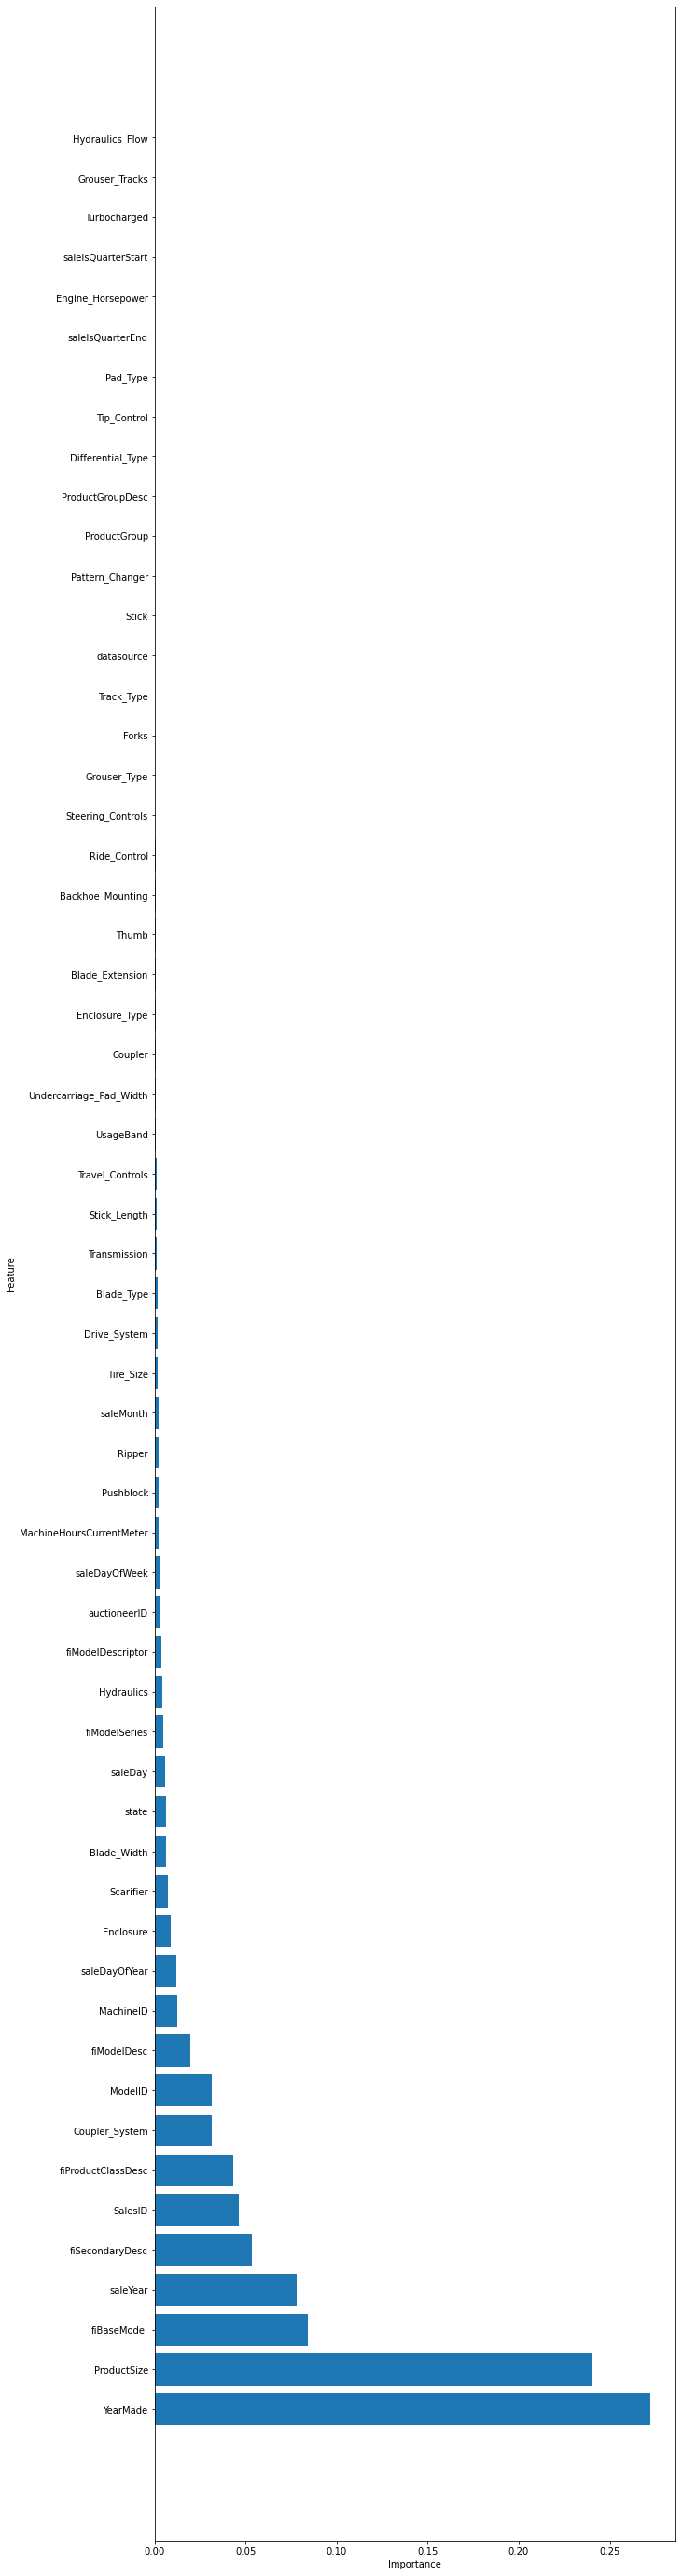

In [122]:
df = pd.DataFrame({'features': X_train.columns, 'importances': best_param_model.feature_importances_}).sort_values('importances', ascending=True).reset_index(drop=True)

fig, ax = plt.subplots(figsize=(10, 50))
ax.barh(df['features'], df['importances'])
ax.set_ylabel('Feature')
ax.set_xlabel('Importance')
ax.invert_yaxis()